In [104]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import copy

In [105]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [106]:
resnet50 = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
# freeze all ResNet parameters since we're only optimizing the target image

for param in resnet50.parameters():
  param.requires_grad_(False)


resnet50.to(device);

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [107]:
resnet50;

In [108]:
def load_image(filepath,maxsize=400):
  """
  see : https://pytorch.org/hub/pytorch_vision_vgg/
  """
  input_image = Image.open(filepath)

  if max(input_image.size) > maxsize:
    size = maxsize
  else :
    size = max(input_image.size)


  preprocess  = transforms.Compose([
    transforms.Resize(size),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

  if torch.cuda.is_available():
    input_batch = input_batch.to(device)
  return input_batch

In [109]:
def im_convert(tensor):
    """ Display a tensor as an image. """
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image


def display_images(im1,im2):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
  # content and style ims side-by-side
  ax1.imshow(im_convert(content))
  ax2.imshow(im_convert(style))

In [110]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram

In [111]:
def get_features(image, model):
  x = image
  features = {}
  # -_-
  x = model.conv1(x)
  x = model.bn1(x)
  x = model.relu(x)
  x = model.maxpool(x)
  i = 0

  for name, layer in model.layer1._modules.items():
    x = layer(x)
    i+=1
    features[f"bneck_{name}_{i}"] = x

  for name, layer in model.layer2._modules.items():
    x = layer(x)
    i+=1
    features[f"bneck_{name}_{i}"] = x

  for name, layer in model.layer3._modules.items():
    x = layer(x)
    i+=1
    features[f"bneck_{name}_{i}"] = x

  for name, layer in model.layer4._modules.items():
    x = layer(x)
    i+=1
    features[f"bneck_{name}_{i}"] = x


  return features     

In [112]:
#content = load_image("/content/drive/MyDrive/mini_projet_IA/rihana.jpg")
#style   = load_image("/content/drive/MyDrive/mini_projet_IA/rain-princess-cropped.jpeg")

content = load_image("/content/drive/MyDrive/mini_projet_IA/smoke.jpg")
style   = load_image("/content/drive/MyDrive/mini_projet_IA/starry_night.jpeg")

In [113]:
content_features = get_features(content, resnet50)
style_features = get_features(style, resnet50)

In [114]:
#for k,_ in content_features.items():
#  print(k)

In [115]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [116]:
#!pip install wandb
import wandb

#wandb.login()

wandb.init(project="resnet_50_style_transfer")

total_loss,161269.60938
content_loss,0.01826
style_loss,0.01613
_runtime,2649
_timestamp,1613000803
_step,19999


total_loss,▅▄▃▂▂▂▂▂▁▁█▄▃▂▂▂▂▂▂▁▄▃▂▂▁▁▁▁▁▁▇▅▅▄▄▄▄▄▄▄
content_loss,▆▆▇▇▇█████▅▇▇▇██████▆▇▇███████▁▁▁▁▁▁▁▁▁▁
style_loss,▅▄▃▂▂▂▂▂▁▁█▄▃▂▂▂▂▂▂▁▄▃▂▂▁▁▁▁▁▁▇▅▅▄▄▄▄▄▄▄
_runtime,▁▁▁▁▁▁▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇██████
_timestamp,▁▁▁▁▁▁▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇██████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [117]:
style_weights= {
  'bneck_0_1':19,
  'bneck_1_2':0,
  'bneck_2_3':7,
  'bneck_0_4':0,
  'bneck_1_5':4,
  'bneck_2_6':3,
  'bneck_3_7':2,
  'bneck_0_8':1,
  'bneck_1_9':1,
  'bneck_2_10':1,
  'bneck_3_11':0.5,
  'bneck_4_12':0.1,
  'bneck_5_13':0.5,
  'bneck_0_14':0.01,
  'bneck_1_15':0.005,
  'bneck_2_16':0.001
  }

Total loss:  115718.8046875
Total loss:  61789.4453125
Total loss:  38267.61328125
Total loss:  25706.71484375
Total loss:  18031.521484375
Total loss:  12985.525390625
Total loss:  9594.63671875
Total loss:  7298.50634765625
Total loss:  5705.4677734375
Total loss:  4570.58203125
Total loss:  3734.618408203125
Total loss:  3104.361572265625
Total loss:  2611.733642578125
Total loss:  2217.8994140625
Total loss:  1897.640380859375
Total loss:  1633.810546875
Total loss:  1414.4825439453125
Total loss:  1230.942138671875
Total loss:  1076.548828125
Total loss:  946.1983032226562
Total loss:  835.371337890625
Total loss:  741.4961547851562
Total loss:  661.702880859375
Total loss:  593.5986938476562
Total loss:  535.706298828125
Total loss:  486.3646240234375
Total loss:  443.7196960449219
Total loss:  406.7621765136719
Total loss:  374.51104736328125
Total loss:  346.2964172363281
Total loss:  321.3950500488281
Total loss:  299.3031005859375
Total loss:  279.5887451171875
Total loss:  2

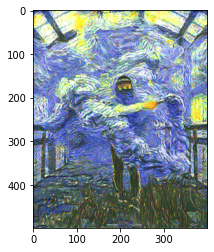

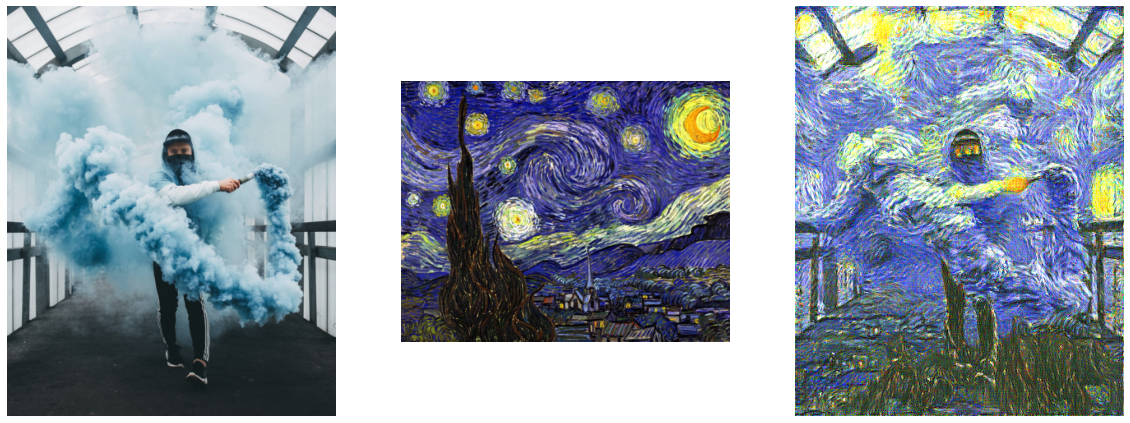

In [121]:
content_weight = 1  # alpha
style_weight = 1e7  # beta
target = content.clone().requires_grad_(True).to(device)

# for displaying the target image, intermittently
show_every = 200

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 20000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, resnet50)
    
    # the content loss
    content_loss = torch.mean((target_features['bneck_4_12'] - content_features['bneck_4_12'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    wandb.log({"total_loss" : total_loss , "content_loss" : content_loss , "style_loss" : style_loss})


    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
      print('Total loss: ', total_loss.item())
      plt.imshow(im_convert(target))
      plt.savefig("RES/img-"+ str(ii)+".jpg")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10) )
# content and style ims side-by-side
ax1.set_axis_off()
ax1.imshow(im_convert(content))
ax2.set_axis_off()
ax2.imshow(im_convert(style))
ax3.set_axis_off()
ax3.imshow(im_convert(target))
print("saving to : "+"/content/drive/MyDrive/mini_projet_IA/resl_"+str(id(target))+".jpg"+ " ....")
fig.savefig("/content/drive/MyDrive/mini_projet_IA/res_"+str(id(target))+".jpg")

In [122]:
!tar -czvf name-of-archive.tar.gz RES  

RES/
RES/img-6600.jpg
RES/img-17400.jpg
RES/img-18400.jpg
RES/img-5200.jpg
RES/img-8400.jpg
RES/img-13000.jpg
RES/img-16000.jpg
RES/img-3600.jpg
RES/img-10000.jpg
RES/img-7600.jpg
RES/img-11400.jpg
RES/img-18800.jpg
RES/img-8800.jpg
RES/img-4600.jpg
RES/img-3400.jpg
RES/img-5800.jpg
RES/img-9800.jpg
RES/img-5400.jpg
RES/img-5600.jpg
RES/img-2000.jpg
RES/img-19200.jpg
RES/img-2600.jpg
RES/img-8000.jpg
RES/img-8200.jpg
RES/img-15200.jpg
RES/img-17600.jpg
RES/img-7800.jpg
RES/img-14400.jpg
RES/img-16400.jpg
RES/img-6400.jpg
RES/img-12800.jpg
RES/img-3200.jpg
RES/img-2800.jpg
RES/img-13400.jpg
RES/img-10800.jpg
RES/img-4000.jpg
RES/img-13600.jpg
RES/img-6200.jpg
RES/img-11000.jpg
RES/img-6000.jpg
RES/img-400.jpg
RES/img-3800.jpg
RES/img-19800.jpg
RES/img-1400.jpg
RES/img-11600.jpg
RES/img-15600.jpg
RES/img-19600.jpg
RES/img-5000.jpg
RES/img-800.jpg
RES/img-18200.jpg
RES/img-20000.jpg
RES/img-14800.jpg
RES/img-1800.jpg
RES/img-13800.jpg
RES/img-16600.jpg
RES/img-7400.jpg
RES/img-1000.jpg
RE

In [123]:
from google.colab import files

files.download('archive.tar.gz')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>